In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from pandas import read_gbq
import datetime
import pytz

In [8]:
# df = read_gbq(f"""

# SELECT *
# FROM capstone-402105.capstone.cri_compustat_data

# """,project_id='capstone-402105', dialect='standard')



In [15]:
df = pd.read_pickle('cri_data.pkl')

In [16]:
df.columns

Index(['CompNo', 'yyyy', 'mm', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration'],
      dtype='object')

In [17]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [18]:
train_df = train_df.drop(columns=['CompNo','yyyy','mm','StartDate','EventDate','Duration', 'dummy297fin'])
validation_df = validation_df.drop(columns=['CompNo','yyyy','mm','StartDate','EventDate','Duration','dummy297fin'])
test_df = test_df.drop(columns=['CompNo','yyyy','mm','StartDate','EventDate','Duration', 'dummy297fin'])

In [19]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [20]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin'],
      dtype='object')

In [21]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1986242, 16), (1986242,), (121006, 16), (121006,), (132975, 16), (132975,))

In [22]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [23]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-08 10:44:48,316] A new study created in memory with name: no-name-1771aabe-0657-45fe-9837-a53a794edd6b


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:45:57,691] Trial 0 finished with value: 0.925036637952405 and parameters: {'num_leaves': 144, 'lambda_l1': 6.939089825021092e-05, 'lambda_l2': 0.4060064250790284, 'feature_fraction': 0.6361772394073076, 'min_child_samples': 63, 'learning_rate': 7.746167820538509e-08, 'max_depth': 198, 'num_boost_round': 372}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 10:47:19,124] Trial 1 finished with value: 0.8041205127685969 and parameters: {'num_leaves': 77, 'lambda_l1': 2.7323370298634504e-07, 'lambda_l2': 0.2799671206704413, 'feature_fraction': 0.8874608033075444, 'min_child_samples': 60, 'learning_rate': 0.4690753226914732, 'max_depth': 127, 'num_boost_round': 489}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:48:06,026] Trial 2 finished with value: 0.9139439118685724 and parameters: {'num_leaves': 88, 'lambda_l1': 3.025603031905395, 'lambda_l2': 4.754169889118892e-08, 'feature_fraction': 0.9513047917008663, 'min_child_samples': 43, 'learning_rate': 3.535633017945323e-07, 'max_depth': 71, 'num_boost_round': 295}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 10:48:23,986] Trial 3 finished with value: 0.8157786099741746 and parameters: {'num_leaves': 96, 'lambda_l1': 0.2182431036372187, 'lambda_l2': 0.03960234511858981, 'feature_fraction': 0.4526230544665946, 'min_child_samples': 82, 'learning_rate': 0.16524942626485442, 'max_depth': 157, 'num_boost_round': 158}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-08 10:48:37,012] Trial 4 finished with value: 0.5401248050158688 and parameters: {'num_leaves': 150, 'lambda_l1': 0.38001163486441303, 'lambda_l2': 2.168771993003725e-06, 'feature_fraction': 0.47565648673335625, 'min_child_samples': 6, 'learning_rate': 1.9668269060480619, 'max_depth': 51, 'num_boost_round': 207}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 10:49:23,658] Trial 5 finished with value: 0.7351551021853846 and parameters: {'num_leaves': 215, 'lambda_l1': 1.499684059465259e-07, 'lambda_l2': 8.180662766383849, 'feature_fraction': 0.4752871797622018, 'min_child_samples': 45, 'learning_rate': 0.8129355638551605, 'max_depth': 55, 'num_boost_round': 266}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:49:38,584] Trial 6 finished with value: 0.9084060672329975 and parameters: {'num_leaves': 7, 'lambda_l1': 2.4417136604266494, 'lambda_l2': 8.480775014885936e-07, 'feature_fraction': 0.40491552746629883, 'min_child_samples': 66, 'learning_rate': 6.909158914632053e-05, 'max_depth': 38, 'num_boost_round': 268}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:50:16,637] Trial 7 finished with value: 0.9204567516649341 and parameters: {'num_leaves': 40, 'lambda_l1': 0.016168862610499008, 'lambda_l2': 1.6323298364840717e-07, 'feature_fraction': 0.5450701871251139, 'min_child_samples': 98, 'learning_rate': 3.4649809018381043e-07, 'max_depth': 91, 'num_boost_round': 334}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-11-08 10:50:46,539] Trial 8 finished with value: 0.49287015033558057 and parameters: {'num_leaves': 248, 'lambda_l1': 0.013403095683622098, 'lambda_l2': 0.0023029082020006577, 'feature_fraction': 0.5428127534847198, 'min_child_samples': 15, 'learning_rate': 2.1888173480766175, 'max_depth': 122, 'num_boost_round': 459}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-11-08 10:50:59,017] Trial 9 finished with value: 0.6968350162645796 and parameters: {'num_leaves': 208, 'lambda_l1': 0.017721248557532314, 'lambda_l2': 0.003098810829018664, 'feature_fraction': 0.6959716883415565, 'min_child_samples': 41, 'learning_rate': 1.558271006163125, 'max_depth': 20, 'num_boost_round': 161}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:52:06,046] Trial 10 finished with value: 0.9247815011840517 and parameters: {'num_leaves': 158, 'lambda_l1': 1.912375701974369e-05, 'lambda_l2': 3.854584141753892e-05, 'feature_fraction': 0.7100176545865969, 'min_child_samples': 29, 'learning_rate': 2.251345059506099e-08, 'max_depth': 239, 'num_boost_round': 390}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:53:22,973] Trial 11 finished with value: 0.9236732504231928 and parameters: {'num_leaves': 150, 'lambda_l1': 2.65405433475641e-05, 'lambda_l2': 5.312081478367029e-05, 'feature_fraction': 0.7293975981509914, 'min_child_samples': 26, 'learning_rate': 1.062543635210193e-08, 'max_depth': 250, 'num_boost_round': 378}. Best is trial 0 with value: 0.925036637952405.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:54:50,791] Trial 12 finished with value: 0.9250540585787844 and parameters: {'num_leaves': 173, 'lambda_l1': 3.4640751955373565e-05, 'lambda_l2': 5.0891246307707985e-05, 'feature_fraction': 0.685075762132599, 'min_child_samples': 30, 'learning_rate': 1.0575172979331522e-08, 'max_depth': 228, 'num_boost_round': 412}. Best is trial 12 with value: 0.9250540585787844.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:56:47,170] Trial 13 finished with value: 0.9263892245126437 and parameters: {'num_leaves': 186, 'lambda_l1': 4.77942655240649e-05, 'lambda_l2': 0.0003359538769136304, 'feature_fraction': 0.6384809208671064, 'min_child_samples': 72, 'learning_rate': 3.948552245447404e-06, 'max_depth': 193, 'num_boost_round': 407}. Best is trial 13 with value: 0.9263892245126437.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:58:40,284] Trial 14 finished with value: 0.9247362969614799 and parameters: {'num_leaves': 191, 'lambda_l1': 3.989798313444707e-06, 'lambda_l2': 0.00012781925503696097, 'feature_fraction': 0.800098942406377, 'min_child_samples': 73, 'learning_rate': 6.186919313786777e-06, 'max_depth': 192, 'num_boost_round': 433}. Best is trial 13 with value: 0.9263892245126437.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:00:00,366] Trial 15 finished with value: 0.9263135725752776 and parameters: {'num_leaves': 180, 'lambda_l1': 0.000741569752435982, 'lambda_l2': 1.1941573252820213e-05, 'feature_fraction': 0.5956813212037877, 'min_child_samples': 84, 'learning_rate': 4.080655515326519e-06, 'max_depth': 203, 'num_boost_round': 430}. Best is trial 13 with value: 0.9263892245126437.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:02:01,066] Trial 16 finished with value: 0.9310082236735459 and parameters: {'num_leaves': 241, 'lambda_l1': 0.0008426408605403065, 'lambda_l2': 1.73488476604296e-06, 'feature_fraction': 0.5933022857693535, 'min_child_samples': 89, 'learning_rate': 0.0007396919927635051, 'max_depth': 173, 'num_boost_round': 493}. Best is trial 16 with value: 0.9310082236735459.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:03:53,281] Trial 17 finished with value: 0.9323975299159296 and parameters: {'num_leaves': 248, 'lambda_l1': 1.0932286088449454e-08, 'lambda_l2': 1.7487596036747417e-08, 'feature_fraction': 0.6129822554754962, 'min_child_samples': 97, 'learning_rate': 0.00238791119452807, 'max_depth': 156, 'num_boost_round': 500}. Best is trial 17 with value: 0.9323975299159296.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:06:02,732] Trial 18 finished with value: 0.9328074068204649 and parameters: {'num_leaves': 254, 'lambda_l1': 1.4393705584239998e-08, 'lambda_l2': 2.8299292683531505e-08, 'feature_fraction': 0.7793116073170318, 'min_child_samples': 99, 'learning_rate': 0.003609528377085085, 'max_depth': 154, 'num_boost_round': 499}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:06:25,986] Trial 19 finished with value: 0.9299711816420808 and parameters: {'num_leaves': 225, 'lambda_l1': 1.588888459320202e-08, 'lambda_l2': 1.594867254482555e-08, 'feature_fraction': 0.795634825113119, 'min_child_samples': 100, 'learning_rate': 0.01918618270658149, 'max_depth': 151, 'num_boost_round': 100}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:08:17,886] Trial 20 finished with value: 0.9324189467202108 and parameters: {'num_leaves': 255, 'lambda_l1': 1.4644500008566525e-08, 'lambda_l2': 1.3278756648353191e-08, 'feature_fraction': 0.7964433058249103, 'min_child_samples': 93, 'learning_rate': 0.003966532451701954, 'max_depth': 95, 'num_boost_round': 461}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:10:26,267] Trial 21 finished with value: 0.9312748793682584 and parameters: {'num_leaves': 252, 'lambda_l1': 1.1861292971021441e-08, 'lambda_l2': 1.0421829710430035e-08, 'feature_fraction': 0.7860576780263221, 'min_child_samples': 91, 'learning_rate': 0.005871853137833879, 'max_depth': 103, 'num_boost_round': 500}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:36:27,651] Trial 22 finished with value: 0.9317109775214677 and parameters: {'num_leaves': 225, 'lambda_l1': 5.769917326497422e-08, 'lambda_l2': 1.0477434947618863e-07, 'feature_fraction': 0.850443839061854, 'min_child_samples': 94, 'learning_rate': 0.001665533408901037, 'max_depth': 154, 'num_boost_round': 459}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:38:29,166] Trial 23 finished with value: 0.9250784104289821 and parameters: {'num_leaves': 250, 'lambda_l1': 6.886058248291808e-07, 'lambda_l2': 2.3281904119361546e-07, 'feature_fraction': 0.7701594877877028, 'min_child_samples': 82, 'learning_rate': 0.01943179730574737, 'max_depth': 99, 'num_boost_round': 461}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:39:30,487] Trial 24 finished with value: 0.9264999660528075 and parameters: {'num_leaves': 116, 'lambda_l1': 1.0155982361221498e-08, 'lambda_l2': 1.0341726761889312e-08, 'feature_fraction': 0.8718662414892085, 'min_child_samples': 76, 'learning_rate': 0.0002024000417251605, 'max_depth': 134, 'num_boost_round': 351}. Best is trial 18 with value: 0.9328074068204649.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:41:19,158] Trial 25 finished with value: 0.932882385954998 and parameters: {'num_leaves': 231, 'lambda_l1': 7.666898489332142e-08, 'lambda_l2': 5.1511006375543226e-08, 'feature_fraction': 0.7388286194139508, 'min_child_samples': 88, 'learning_rate': 0.0032007019722575638, 'max_depth': 81, 'num_boost_round': 461}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:42:24,327] Trial 26 finished with value: 0.9096326635606716 and parameters: {'num_leaves': 197, 'lambda_l1': 1.0794997011102653e-06, 'lambda_l2': 9.575444932636853e-08, 'feature_fraction': 0.748988859596858, 'min_child_samples': 87, 'learning_rate': 0.06749842730564984, 'max_depth': 77, 'num_boost_round': 448}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:42:38,664] Trial 27 finished with value: 0.9201593095962836 and parameters: {'num_leaves': 228, 'lambda_l1': 6.282941581881072e-08, 'lambda_l2': 5.485987814587082e-07, 'feature_fraction': 0.829034619611043, 'min_child_samples': 81, 'learning_rate': 0.007855310995273184, 'max_depth': 2, 'num_boost_round': 321}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:44:18,171] Trial 28 finished with value: 0.9313093639000515 and parameters: {'num_leaves': 233, 'lambda_l1': 8.01641103937875e-08, 'lambda_l2': 4.5415788409274055e-06, 'feature_fraction': 0.7380298958651494, 'min_child_samples': 54, 'learning_rate': 0.0004729610158866269, 'max_depth': 113, 'num_boost_round': 422}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:45:23,826] Trial 29 finished with value: 0.914137642960894 and parameters: {'num_leaves': 215, 'lambda_l1': 2.503524595232026e-06, 'lambda_l2': 4.437370601993363e-07, 'feature_fraction': 0.9190963611499186, 'min_child_samples': 68, 'learning_rate': 0.059047153319432534, 'max_depth': 81, 'num_boost_round': 369}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-08 11:45:48,298] Trial 30 finished with value: 0.5660247203474703 and parameters: {'num_leaves': 256, 'lambda_l1': 3.993526432141214e-07, 'lambda_l2': 4.3220588592819336e-08, 'feature_fraction': 0.8230809147280618, 'min_child_samples': 92, 'learning_rate': 8.842203636575887, 'max_depth': 136, 'num_boost_round': 468}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:47:42,370] Trial 31 finished with value: 0.9322563496918825 and parameters: {'num_leaves': 204, 'lambda_l1': 4.176586634073817e-08, 'lambda_l2': 3.0844824947782175e-08, 'feature_fraction': 0.6850597550221899, 'min_child_samples': 99, 'learning_rate': 0.0026779531439542694, 'max_depth': 172, 'num_boost_round': 479}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:49:38,765] Trial 32 finished with value: 0.9318179892955895 and parameters: {'num_leaves': 235, 'lambda_l1': 2.515699056568228e-07, 'lambda_l2': 4.604833618675917e-08, 'feature_fraction': 0.7644811299223213, 'min_child_samples': 96, 'learning_rate': 0.0021377813951863594, 'max_depth': 172, 'num_boost_round': 500}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:50:24,789] Trial 33 finished with value: 0.9273794367576446 and parameters: {'num_leaves': 127, 'lambda_l1': 3.094331239958623e-08, 'lambda_l2': 1.8371360239147794e-07, 'feature_fraction': 0.9008236406142294, 'min_child_samples': 60, 'learning_rate': 0.00018094800823303058, 'max_depth': 114, 'num_boost_round': 441}. Best is trial 25 with value: 0.932882385954998.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:51:24,592] Trial 34 finished with value: 0.9337560136607332 and parameters: {'num_leaves': 256, 'lambda_l1': 1.5318851524079121e-07, 'lambda_l2': 3.184434033308506e-08, 'feature_fraction': 0.832407098437592, 'min_child_samples': 88, 'learning_rate': 0.009989181630792147, 'max_depth': 137, 'num_boost_round': 477}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.641114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:52:13,396] Trial 35 finished with value: 0.8000291355234965 and parameters: {'num_leaves': 256, 'lambda_l1': 2.1986475947627844e-07, 'lambda_l2': 5.549684866080874e-08, 'feature_fraction': 0.8679843556603246, 'min_child_samples': 79, 'learning_rate': 0.1508899619973302, 'max_depth': 59, 'num_boost_round': 474}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:52:52,671] Trial 36 finished with value: 0.9317329271494691 and parameters: {'num_leaves': 65, 'lambda_l1': 1.7048646820806143e-07, 'lambda_l2': 3.6001476214595783e-07, 'feature_fraction': 0.9889266919498807, 'min_child_samples': 88, 'learning_rate': 0.011716125671256971, 'max_depth': 133, 'num_boost_round': 399}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:53:32,769] Trial 37 finished with value: 0.912695596201115 and parameters: {'num_leaves': 218, 'lambda_l1': 3.623340449112265e-08, 'lambda_l2': 1.1009201250853235e-06, 'feature_fraction': 0.8251072685812, 'min_child_samples': 85, 'learning_rate': 0.04632008406537445, 'max_depth': 66, 'num_boost_round': 445}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:53:57,515] Trial 38 finished with value: 0.7110384665672892 and parameters: {'num_leaves': 235, 'lambda_l1': 1.2081495068593587e-07, 'lambda_l2': 8.106318802733155e-08, 'feature_fraction': 0.8450046646961712, 'min_child_samples': 77, 'learning_rate': 0.31349958057174243, 'max_depth': 89, 'num_boost_round': 257}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:54:53,049] Trial 39 finished with value: 0.931075657482345 and parameters: {'num_leaves': 164, 'lambda_l1': 8.75098924213214e-07, 'lambda_l2': 2.7610322162195967e-08, 'feature_fraction': 0.7959523472682727, 'min_child_samples': 92, 'learning_rate': 0.0010249230623825465, 'max_depth': 143, 'num_boost_round': 481}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:55:27,698] Trial 40 finished with value: 0.9318787718387961 and parameters: {'num_leaves': 206, 'lambda_l1': 3.0808808606191854e-08, 'lambda_l2': 1.8919684251733996e-07, 'feature_fraction': 0.9042950229434836, 'min_child_samples': 54, 'learning_rate': 0.0053606984465195085, 'max_depth': 30, 'num_boost_round': 287}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 11:56:24,233] Trial 41 finished with value: 0.9318354370147004 and parameters: {'num_leaves': 238, 'lambda_l1': 1.4784933072872292e-08, 'lambda_l2': 1.0681386777704892e-08, 'feature_fraction': 0.7268821513733494, 'min_child_samples': 95, 'learning_rate': 0.0028187364828953193, 'max_depth': 120, 'num_boost_round': 482}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:57:20,911] Trial 42 finished with value: 0.9317752550270428 and parameters: {'num_leaves': 243, 'lambda_l1': 7.382314697703691e-08, 'lambda_l2': 2.9674394715098984e-08, 'feature_fraction': 0.7587864462602749, 'min_child_samples': 100, 'learning_rate': 0.0006739973027943373, 'max_depth': 101, 'num_boost_round': 457}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:15:59,029] Trial 43 finished with value: 0.9289569426596606 and parameters: {'num_leaves': 246, 'lambda_l1': 1.4129164417453847e-07, 'lambda_l2': 7.417927457095829e-08, 'feature_fraction': 0.6652292883797993, 'min_child_samples': 88, 'learning_rate': 0.020085172242190287, 'max_depth': 150, 'num_boost_round': 227}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:17:00,190] Trial 44 finished with value: 0.9326147233137633 and parameters: {'num_leaves': 221, 'lambda_l1': 2.4364987258625883e-08, 'lambda_l2': 2.5006110064070536e-08, 'feature_fraction': 0.7164540670010989, 'min_child_samples': 95, 'learning_rate': 0.0040661345527182105, 'max_depth': 44, 'num_boost_round': 425}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:17:55,634] Trial 45 finished with value: 0.9321095341796752 and parameters: {'num_leaves': 217, 'lambda_l1': 3.379061257652273e-07, 'lambda_l2': 7.308881085335595e-07, 'feature_fraction': 0.7148281770603079, 'min_child_samples': 68, 'learning_rate': 0.005161068173600068, 'max_depth': 38, 'num_boost_round': 424}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 12:18:47,591] Trial 46 finished with value: 0.9304281321676644 and parameters: {'num_leaves': 223, 'lambda_l1': 2.847211834692256e-08, 'lambda_l2': 2.987185026319526e-07, 'feature_fraction': 0.7356536958289818, 'min_child_samples': 83, 'learning_rate': 0.0002984390607683492, 'max_depth': 49, 'num_boost_round': 389}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 12:19:42,013] Trial 47 finished with value: 0.9287552959742749 and parameters: {'num_leaves': 199, 'lambda_l1': 9.674983797126327e-08, 'lambda_l2': 2.7127034989483843e-06, 'feature_fraction': 0.7832798661898502, 'min_child_samples': 93, 'learning_rate': 7.242059555000038e-05, 'max_depth': 13, 'num_boost_round': 414}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 12:20:30,421] Trial 48 finished with value: 0.9313185483360429 and parameters: {'num_leaves': 212, 'lambda_l1': 3.7506810964622267e-06, 'lambda_l2': 1.126573758712147e-07, 'feature_fraction': 0.7012822445714142, 'min_child_samples': 74, 'learning_rate': 0.0009971633256239212, 'max_depth': 73, 'num_boost_round': 358}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:20:45,004] Trial 49 finished with value: 0.9168248897240033 and parameters: {'num_leaves': 2, 'lambda_l1': 2.0691531364471e-08, 'lambda_l2': 2.441869732637605e-08, 'feature_fraction': 0.8091578870362954, 'min_child_samples': 39, 'learning_rate': 0.01284487491794149, 'max_depth': 88, 'num_boost_round': 471}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:21:09,552] Trial 50 finished with value: 0.9258717488248032 and parameters: {'num_leaves': 23, 'lambda_l1': 5.076212751046638e-07, 'lambda_l2': 7.578154845980642e-07, 'feature_fraction': 0.7717354390802661, 'min_child_samples': 15, 'learning_rate': 0.03735701285953893, 'max_depth': 46, 'num_boost_round': 438}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:22:18,571] Trial 51 finished with value: 0.9314149487903123 and parameters: {'num_leaves': 241, 'lambda_l1': 1.0014204340006463e-08, 'lambda_l2': 2.033759239862515e-08, 'feature_fraction': 0.666304784335199, 'min_child_samples': 96, 'learning_rate': 0.00182826157156722, 'max_depth': 179, 'num_boost_round': 489}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:23:30,632] Trial 52 finished with value: 0.9313786625918715 and parameters: {'num_leaves': 256, 'lambda_l1': 2.612754168961221e-08, 'lambda_l2': 1.9173614075319463e-08, 'feature_fraction': 0.7417463798975314, 'min_child_samples': 97, 'learning_rate': 0.004601772616176131, 'max_depth': 159, 'num_boost_round': 498}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:24:31,630] Trial 53 finished with value: 0.932076598449035 and parameters: {'num_leaves': 230, 'lambda_l1': 7.253332185358267e-08, 'lambda_l2': 5.132830991925296e-08, 'feature_fraction': 0.7091399982207196, 'min_child_samples': 90, 'learning_rate': 0.008178952518231367, 'max_depth': 213, 'num_boost_round': 454}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 12:40:00,123] Trial 54 finished with value: 0.9314180599389839 and parameters: {'num_leaves': 247, 'lambda_l1': 1.0394983871277903e-08, 'lambda_l2': 1.046091590416814e-08, 'feature_fraction': 0.7540850856973765, 'min_child_samples': 85, 'learning_rate': 0.000986172045393441, 'max_depth': 162, 'num_boost_round': 467}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:41:11,662] Trial 55 finished with value: 0.9328325849989748 and parameters: {'num_leaves': 97, 'lambda_l1': 1.5728644633009133e-07, 'lambda_l2': 1.458741492766505e-07, 'feature_fraction': 0.802999341009988, 'min_child_samples': 100, 'learning_rate': 0.0034626680393733474, 'max_depth': 122, 'num_boost_round': 484}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:41:59,293] Trial 56 finished with value: 0.924487671479606 and parameters: {'num_leaves': 98, 'lambda_l1': 2.5440885557923765e-07, 'lambda_l2': 1.6352577268648907e-07, 'feature_fraction': 0.8092591844863593, 'min_child_samples': 100, 'learning_rate': 0.027661871058767478, 'max_depth': 123, 'num_boost_round': 433}. Best is trial 34 with value: 0.9337560136607332.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:42:59,338] Trial 57 finished with value: 0.9352986647636249 and parameters: {'num_leaves': 87, 'lambda_l1': 1.4811450484601312e-07, 'lambda_l2': 8.799553848521354e-08, 'feature_fraction': 0.7810323703851044, 'min_child_samples': 91, 'learning_rate': 0.012126750978785407, 'max_depth': 106, 'num_boost_round': 485}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:44:10,297] Trial 58 finished with value: 0.9332310378017118 and parameters: {'num_leaves': 79, 'lambda_l1': 1.9036307418142992e-06, 'lambda_l2': 3.148228073435607e-07, 'feature_fraction': 0.7829588603043619, 'min_child_samples': 80, 'learning_rate': 0.009669654667670823, 'max_depth': 105, 'num_boost_round': 483}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:45:03,970] Trial 59 finished with value: 0.8628704689461033 and parameters: {'num_leaves': 79, 'lambda_l1': 1.1497386917215076e-06, 'lambda_l2': 3.36086763566997e-07, 'feature_fraction': 0.8473883730289282, 'min_child_samples': 79, 'learning_rate': 0.10383815086143937, 'max_depth': 108, 'num_boost_round': 486}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:46:02,710] Trial 60 finished with value: 0.933218981536177 and parameters: {'num_leaves': 56, 'lambda_l1': 2.146508546937923e-06, 'lambda_l2': 1.4654281798236915e-06, 'feature_fraction': 0.775291235713517, 'min_child_samples': 71, 'learning_rate': 0.010573090078568933, 'max_depth': 125, 'num_boost_round': 479}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:46:59,157] Trial 61 finished with value: 0.9269915275429313 and parameters: {'num_leaves': 68, 'lambda_l1': 2.1983322404438646e-06, 'lambda_l2': 9.993444141203517e-08, 'feature_fraction': 0.7791045342420992, 'min_child_samples': 86, 'learning_rate': 0.0273096128997606, 'max_depth': 144, 'num_boost_round': 481}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:47:56,711] Trial 62 finished with value: 0.9343477234329893 and parameters: {'num_leaves': 48, 'lambda_l1': 5.11420441171461e-07, 'lambda_l2': 1.4048993880304023e-06, 'feature_fraction': 0.7767172237901401, 'min_child_samples': 70, 'learning_rate': 0.009223060696842705, 'max_depth': 127, 'num_boost_round': 452}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:49:01,392] Trial 63 finished with value: 0.9341261726208332 and parameters: {'num_leaves': 52, 'lambda_l1': 9.693933190173939e-06, 'lambda_l2': 1.3106467857855157e-06, 'feature_fraction': 0.8109936653989587, 'min_child_samples': 70, 'learning_rate': 0.011478065319419552, 'max_depth': 126, 'num_boost_round': 447}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:49:58,431] Trial 64 finished with value: 0.9343997911475512 and parameters: {'num_leaves': 48, 'lambda_l1': 6.424390555494486e-07, 'lambda_l2': 1.523709208746461e-06, 'feature_fraction': 0.7618387417591401, 'min_child_samples': 64, 'learning_rate': 0.011702793765319483, 'max_depth': 115, 'num_boost_round': 450}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:50:50,668] Trial 65 finished with value: 0.9334338946291062 and parameters: {'num_leaves': 47, 'lambda_l1': 5.111583357063724e-06, 'lambda_l2': 4.920755136753118e-06, 'feature_fraction': 0.8211797324049382, 'min_child_samples': 65, 'learning_rate': 0.012813412255316724, 'max_depth': 129, 'num_boost_round': 404}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:51:36,192] Trial 66 finished with value: 0.933274381656718 and parameters: {'num_leaves': 42, 'lambda_l1': 1.0315293123205733e-05, 'lambda_l2': 6.839772333057574e-06, 'feature_fraction': 0.8305528408860077, 'min_child_samples': 60, 'learning_rate': 0.015831945373463305, 'max_depth': 115, 'num_boost_round': 404}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:52:03,686] Trial 67 finished with value: 0.833643078512406 and parameters: {'num_leaves': 37, 'lambda_l1': 7.599461034970223e-06, 'lambda_l2': 7.659299434865367e-06, 'feature_fraction': 0.8331171684762554, 'min_child_samples': 63, 'learning_rate': 0.11012032160931345, 'max_depth': 142, 'num_boost_round': 396}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:52:31,121] Trial 68 finished with value: 0.8068162440721329 and parameters: {'num_leaves': 45, 'lambda_l1': 6.194880319197208e-06, 'lambda_l2': 2.1631455640265937e-06, 'feature_fraction': 0.8679051347912556, 'min_child_samples': 50, 'learning_rate': 0.2718389900554139, 'max_depth': 112, 'num_boost_round': 378}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:53:04,141] Trial 69 finished with value: 0.9223816857252896 and parameters: {'num_leaves': 20, 'lambda_l1': 1.4179770106038065e-05, 'lambda_l2': 1.555699280360106e-05, 'feature_fraction': 0.8186875913496674, 'min_child_samples': 58, 'learning_rate': 0.06924011582285787, 'max_depth': 130, 'num_boost_round': 411}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:53:55,769] Trial 70 finished with value: 0.9341951326535093 and parameters: {'num_leaves': 52, 'lambda_l1': 8.77679264813952e-05, 'lambda_l2': 2.9290019420975734e-06, 'feature_fraction': 0.8399927053091778, 'min_child_samples': 61, 'learning_rate': 0.015762384432702305, 'max_depth': 96, 'num_boost_round': 333}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:54:45,184] Trial 71 finished with value: 0.9331436005261265 and parameters: {'num_leaves': 51, 'lambda_l1': 4.9052275586015506e-05, 'lambda_l2': 5.65706279282546e-06, 'feature_fraction': 0.8347514477810412, 'min_child_samples': 64, 'learning_rate': 0.01857926161918132, 'max_depth': 95, 'num_boost_round': 317}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:55:19,518] Trial 72 finished with value: 0.9265429622177589 and parameters: {'num_leaves': 33, 'lambda_l1': 2.6726414611983958e-05, 'lambda_l2': 2.9994326599142675e-06, 'feature_fraction': 0.8161171935489338, 'min_child_samples': 58, 'learning_rate': 0.033404482480508195, 'max_depth': 117, 'num_boost_round': 343}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:56:34,841] Trial 73 finished with value: 0.9323466407351897 and parameters: {'num_leaves': 60, 'lambda_l1': 9.74574889300524e-05, 'lambda_l2': 1.6184941880330378e-06, 'feature_fraction': 0.8580341768853101, 'min_child_samples': 70, 'learning_rate': 0.011719049782834412, 'max_depth': 138, 'num_boost_round': 444}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:57:13,550] Trial 74 finished with value: 0.9163962917419747 and parameters: {'num_leaves': 27, 'lambda_l1': 5.012499422706697e-07, 'lambda_l2': 1.0391323544381335e-06, 'feature_fraction': 0.8835937587105933, 'min_child_samples': 49, 'learning_rate': 0.08589077746400638, 'max_depth': 130, 'num_boost_round': 406}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:57:46,378] Trial 75 finished with value: 0.9276809382205708 and parameters: {'num_leaves': 15, 'lambda_l1': 1.0672220333197085e-06, 'lambda_l2': 4.216615356582146e-06, 'feature_fraction': 0.7962989139787965, 'min_child_samples': 66, 'learning_rate': 0.05547755520295821, 'max_depth': 108, 'num_boost_round': 365}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:58:37,944] Trial 76 finished with value: 0.9287575672482689 and parameters: {'num_leaves': 49, 'lambda_l1': 1.0805991667590866e-05, 'lambda_l2': 6.374284799489484e-07, 'feature_fraction': 0.8431534964380911, 'min_child_samples': 61, 'learning_rate': 0.022556641274921862, 'max_depth': 97, 'num_boost_round': 452}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:59:05,177] Trial 77 finished with value: 0.7710891312395938 and parameters: {'num_leaves': 43, 'lambda_l1': 4.146136693295007e-06, 'lambda_l2': 1.617736689350656e-05, 'feature_fraction': 0.8573293224524247, 'min_child_samples': 57, 'learning_rate': 0.18285148292782372, 'max_depth': 83, 'num_boost_round': 382}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 12:59:28,857] Trial 78 finished with value: 0.9309220462099771 and parameters: {'num_leaves': 71, 'lambda_l1': 1.5862838530336023e-05, 'lambda_l2': 7.727134149926318e-06, 'feature_fraction': 0.8245222566347893, 'min_child_samples': 66, 'learning_rate': 0.016205379412544615, 'max_depth': 128, 'num_boost_round': 145}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:39:56,458] Trial 79 finished with value: 0.9315057636264293 and parameters: {'num_leaves': 57, 'lambda_l1': 6.1003756010647e-07, 'lambda_l2': 1.3421607277089884e-06, 'feature_fraction': 0.7549909132738019, 'min_child_samples': 76, 'learning_rate': 0.00708409727504985, 'max_depth': 114, 'num_boost_round': 328}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:40:57,491] Trial 80 finished with value: 0.9157764732607472 and parameters: {'num_leaves': 87, 'lambda_l1': 0.00010539786951817871, 'lambda_l2': 2.8397241815023195e-05, 'feature_fraction': 0.7889641187120726, 'min_child_samples': 55, 'learning_rate': 0.04161288085833172, 'max_depth': 137, 'num_boost_round': 418}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:41:58,055] Trial 81 finished with value: 0.9313619463765124 and parameters: {'num_leaves': 33, 'lambda_l1': 2.125159956502792e-06, 'lambda_l2': 4.740680789596352e-07, 'feature_fraction': 0.8075266392061324, 'min_child_samples': 63, 'learning_rate': 0.0070035575721659185, 'max_depth': 108, 'num_boost_round': 468}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:43:16,583] Trial 82 finished with value: 0.9346862787217496 and parameters: {'num_leaves': 78, 'lambda_l1': 8.511089861003025e-06, 'lambda_l2': 3.497553146778156e-06, 'feature_fraction': 0.7632955128185537, 'min_child_samples': 74, 'learning_rate': 0.00996359737307501, 'max_depth': 106, 'num_boost_round': 430}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 13:44:36,554] Trial 83 finished with value: 0.9307617565792847 and parameters: {'num_leaves': 87, 'lambda_l1': 8.894086386448465e-06, 'lambda_l2': 2.823946190611624e-06, 'feature_fraction': 0.7616826566003669, 'min_child_samples': 69, 'learning_rate': 0.001572284219468766, 'max_depth': 90, 'num_boost_round': 437}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:45:50,967] Trial 84 finished with value: 0.9308784404585657 and parameters: {'num_leaves': 108, 'lambda_l1': 3.1133848827958126e-05, 'lambda_l2': 4.136508138748244e-06, 'feature_fraction': 0.8361980179246953, 'min_child_samples': 75, 'learning_rate': 0.015786056970483124, 'max_depth': 146, 'num_boost_round': 429}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:46:38,587] Trial 85 finished with value: 0.92272931256366 and parameters: {'num_leaves': 74, 'lambda_l1': 1.656211050399052e-05, 'lambda_l2': 8.695394816823732e-07, 'feature_fraction': 0.7674990074193705, 'min_child_samples': 73, 'learning_rate': 0.037156161124369765, 'max_depth': 103, 'num_boost_round': 399}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:47:43,752] Trial 86 finished with value: 0.9327747736253269 and parameters: {'num_leaves': 63, 'lambda_l1': 6.474129717576656e-06, 'lambda_l2': 8.939564851611678e-06, 'feature_fraction': 0.819290204817237, 'min_child_samples': 65, 'learning_rate': 0.006140969616390113, 'max_depth': 119, 'num_boost_round': 446}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:49:08,477] Trial 87 finished with value: 0.9326096569729656 and parameters: {'num_leaves': 134, 'lambda_l1': 3.5484380514520305e-07, 'lambda_l2': 1.7189599360163203e-06, 'feature_fraction': 0.7988733566642612, 'min_child_samples': 61, 'learning_rate': 0.012475917966731526, 'max_depth': 68, 'num_boost_round': 461}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:50:16,146] Trial 88 finished with value: 0.9307800306267074 and parameters: {'num_leaves': 50, 'lambda_l1': 3.833693711657699e-06, 'lambda_l2': 5.343099696495593e-07, 'feature_fraction': 0.7458140159023592, 'min_child_samples': 67, 'learning_rate': 0.0027328579776284777, 'max_depth': 97, 'num_boost_round': 450}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:51:07,108] Trial 89 finished with value: 0.932171725544922 and parameters: {'num_leaves': 38, 'lambda_l1': 1.413676209659445e-06, 'lambda_l2': 2.5907194318105105e-06, 'feature_fraction': 0.786826722946002, 'min_child_samples': 71, 'learning_rate': 0.021286865801246915, 'max_depth': 126, 'num_boost_round': 418}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:51:28,580] Trial 90 finished with value: 0.9254732869911557 and parameters: {'num_leaves': 14, 'lambda_l1': 7.433987805588321e-07, 'lambda_l2': 1.1731431590155036e-05, 'feature_fraction': 0.7292913955179194, 'min_child_samples': 50, 'learning_rate': 0.054826164674060714, 'max_depth': 113, 'num_boost_round': 304}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:52:55,725] Trial 91 finished with value: 0.9348731147138946 and parameters: {'num_leaves': 75, 'lambda_l1': 1.4654433413229154e-06, 'lambda_l2': 9.724649730112102e-07, 'feature_fraction': 0.779592431379685, 'min_child_samples': 80, 'learning_rate': 0.009502319846278421, 'max_depth': 109, 'num_boost_round': 472}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:53:28,545] Trial 92 finished with value: 0.9333585813508843 and parameters: {'num_leaves': 54, 'lambda_l1': 1.2747283802970463e-06, 'lambda_l2': 1.0151599085607446e-06, 'feature_fraction': 0.8088500424210655, 'min_child_samples': 82, 'learning_rate': 0.008242795974542102, 'max_depth': 133, 'num_boost_round': 473}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:54:01,121] Trial 93 finished with value: 0.9321166821453463 and parameters: {'num_leaves': 54, 'lambda_l1': 7.287659952628147e-07, 'lambda_l2': 1.014548219591348e-06, 'feature_fraction': 0.7717485275869361, 'min_child_samples': 83, 'learning_rate': 0.005169577300147361, 'max_depth': 135, 'num_boost_round': 471}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:54:36,823] Trial 94 finished with value: 0.9343344615409013 and parameters: {'num_leaves': 62, 'lambda_l1': 2.3181928876490773e-07, 'lambda_l2': 2.393679945713425e-07, 'feature_fraction': 0.8066873235374634, 'min_child_samples': 78, 'learning_rate': 0.010232091644244138, 'max_depth': 84, 'num_boost_round': 491}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:55:28,377] Trial 95 finished with value: 0.9311006053726367 and parameters: {'num_leaves': 83, 'lambda_l1': 1.884099280175692e-07, 'lambda_l2': 2.3401473724269727e-07, 'feature_fraction': 0.7930134468895227, 'min_child_samples': 78, 'learning_rate': 0.0015733967049812506, 'max_depth': 85, 'num_boost_round': 492}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:56:10,793] Trial 96 finished with value: 0.9317991688780807 and parameters: {'num_leaves': 65, 'lambda_l1': 3.3119579556266614e-07, 'lambda_l2': 4.486277781493562e-07, 'feature_fraction': 0.7681304475913896, 'min_child_samples': 72, 'learning_rate': 0.003953932820069319, 'max_depth': 58, 'num_boost_round': 459}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:56:32,528] Trial 97 finished with value: 0.9334267918179877 and parameters: {'num_leaves': 104, 'lambda_l1': 1.0360334985646367e-07, 'lambda_l2': 2.0602871507825089e-07, 'feature_fraction': 0.7519057947945137, 'min_child_samples': 76, 'learning_rate': 0.028769388750379987, 'max_depth': 77, 'num_boost_round': 247}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:57:11,099] Trial 98 finished with value: 0.9337208698724724 and parameters: {'num_leaves': 73, 'lambda_l1': 4.297260514013675e-07, 'lambda_l2': 4.27984459375266e-06, 'feature_fraction': 0.8453185076241767, 'min_child_samples': 69, 'learning_rate': 0.011066386459122534, 'max_depth': 102, 'num_boost_round': 433}. Best is trial 57 with value: 0.9352986647636249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


[I 2023-11-08 13:57:57,541] Trial 99 finished with value: 0.9322554195080996 and parameters: {'num_leaves': 73, 'lambda_l1': 2.382570043596407e-07, 'lambda_l2': 1.77391027360242e-06, 'feature_fraction': 0.8485630972363001, 'min_child_samples': 74, 'learning_rate': 0.0023963857380858724, 'max_depth': 103, 'num_boost_round': 494}. Best is trial 57 with value: 0.9352986647636249.


In [24]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16963, number of negative: 1969279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1986242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008540 -> initscore=-4.754388
[LightGBM] [Info] Start training from score -4.754388


In [25]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

Accuracy: 0.9938928648166206
Recall: 0.030831099195710455
Precision: 0.5897435897435898
F1 Score: 0.058598726114649675
AUC: 0.8939816389779249


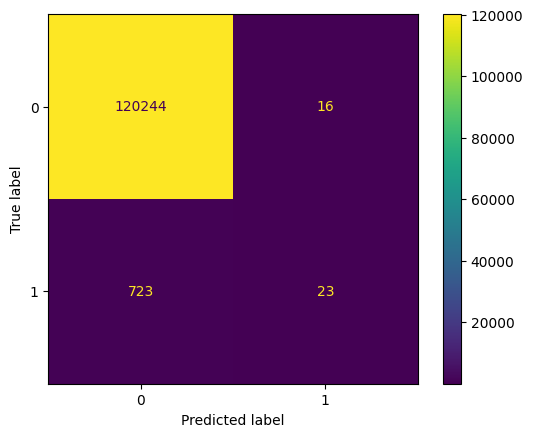

In [26]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

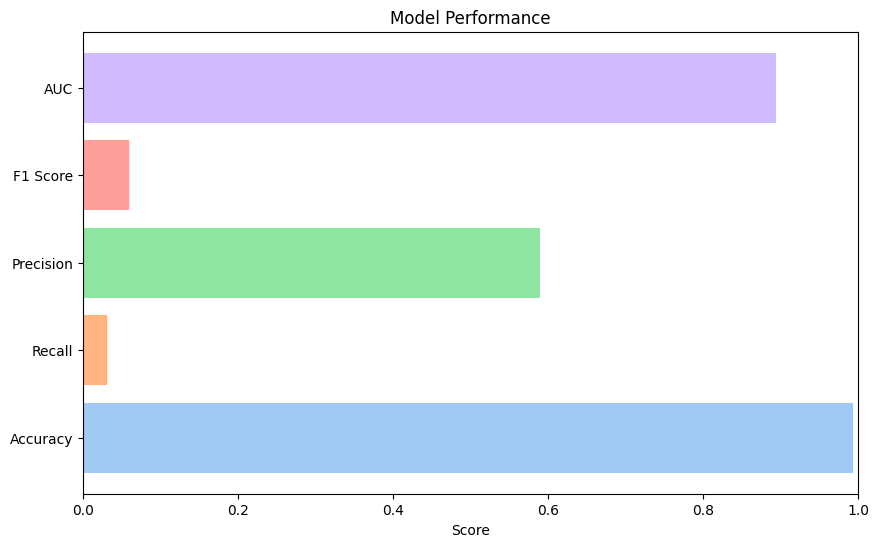

In [27]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [28]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.11957649436869523
average_precision_score 0.12059423261200786


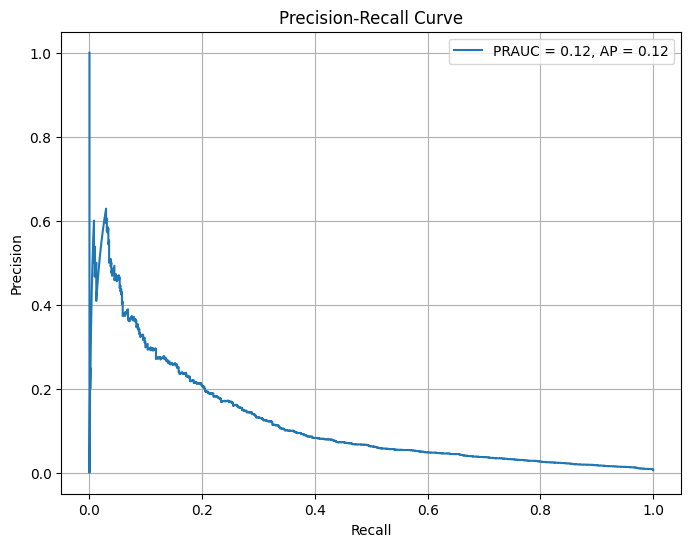

In [29]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [30]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

            feature  importance
8         sizelevel        4493
4    liqnonfinlevel        4055
6        ni2talevel        4022
10              m2b        3485
1             STInt        3388
2          dtdlevel        3353
11            sigma        3317
15  DTDmedianNonFin        3043
7        ni2tatrend        2448
5    liqnonfintrend        2220
3          dtdtrend        2163
9         sizetrend        1920
0           StkIndx        1625
12      liqfinlevel        1093
14     DTDmedianFin         694
13       lqfintrend         391


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


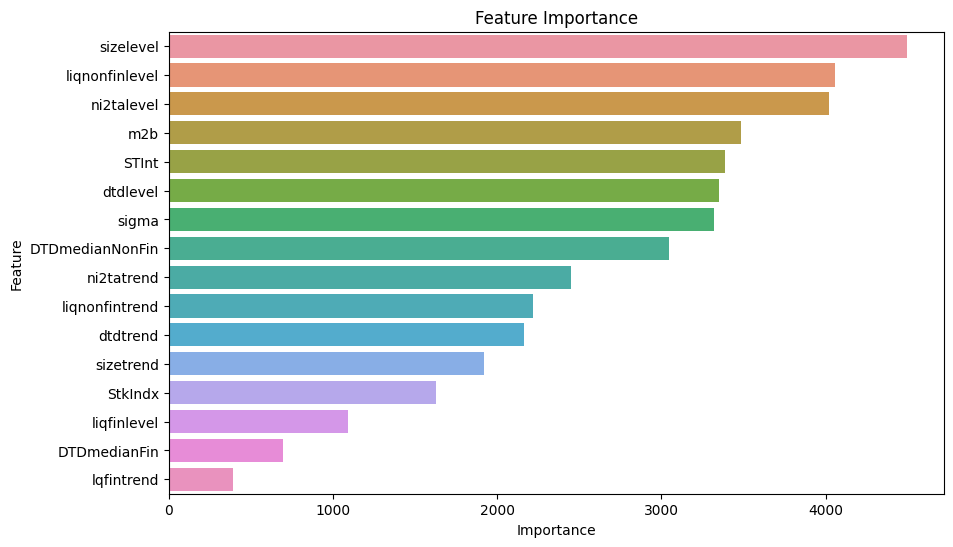

In [31]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

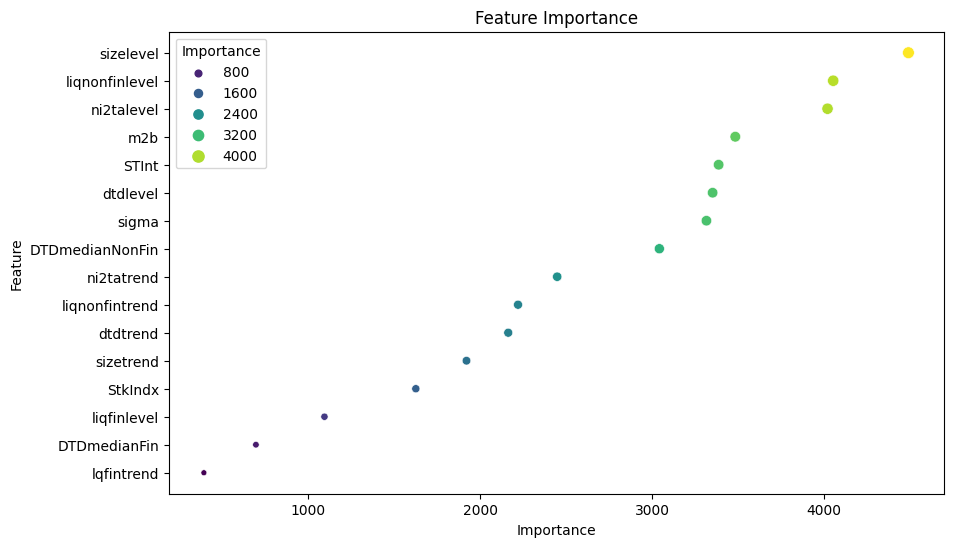

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()